<a href="https://colab.research.google.com/github/Veenasjsu/DeepLearning/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install datasets

In [12]:
from transformers import BertTokenizer, BertForQuestionAnswering, RobertaTokenizer, RobertaForQuestionAnswering, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import torch


In [13]:
!pip install gradio

In [14]:
# Load dataset
dataset = load_dataset("squad_v2")

# Load pre-trained models and tokenizers
bert_model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

roberta_model = RobertaForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")
roberta_tokenizer = RobertaTokenizer.from_pretrained("deepset/roberta-base-squad2")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [15]:
import string
import re

# Function to normalize answer
def normalize_answer(s):
    """Lower text and remove punctuation, articles, and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punctuation(text):
        return ''.join(ch for ch in text if ch not in set(string.punctuation))

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punctuation(lower(s))))



In [16]:
# Define a function to evaluate the models
def evaluate_model(model, tokenizer, dataset):
    # Tokenize the dataset
    inputs = tokenizer(dataset['context'], dataset['question'], truncation=True, padding=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs


In [17]:
# Function to compute evaluation metrics (F1 and EM)
def compute_metrics(prediction, reference):
    normalized_pred = normalize_answer(prediction)
    normalized_ref = normalize_answer(reference)

    # Compute F1
    pred_tokens = normalized_pred.split()
    ref_tokens = normalized_ref.split()
    common = set(pred_tokens) & set(ref_tokens)
    if len(common) == 0:
        f1 = 0.0
    else:
        precision = len(common) / len(pred_tokens)
        recall = len(common) / len(ref_tokens)
        f1 = 2 * (precision * recall) / (precision + recall)

    # Compute Exact Match (EM)
    em = int(normalized_pred == normalized_ref)

    return {'f1': f1 * 100, 'exact_match': em * 100}

In [18]:
import gradio as gr

def answer_question(paragraph, question, model_choice, ground_truth=""):
    try:
        if model_choice == "BERT":
            model, tokenizer = bert_model, bert_tokenizer
        else:
            model, tokenizer = roberta_model, roberta_tokenizer

        # Tokenize inputs
        inputs = tokenizer(question, paragraph, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the answer
        start_idx = torch.argmax(outputs.start_logits)
        end_idx = torch.argmax(outputs.end_logits)

        # Ensure end_idx is greater than or equal to start_idx
        if end_idx < start_idx:
            end_idx = start_idx

        answer_tokens = inputs.input_ids[0][start_idx:end_idx + 1]
        answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

        # Compute metrics if ground truth is provided
        if ground_truth:
            metrics = compute_metrics(answer, ground_truth)
            return f"Answer: {answer}\n\nF1 Score: {metrics['f1']:.2f}%\nExact Match: {metrics['exact_match']:.2f}%"
        else:
            return f"Answer: {answer}"

    except Exception as e:
        return f"Error: {str(e)}"


# Gradio Interface
iface = gr.Interface(
    fn=answer_question,
    inputs=[
        gr.Textbox(lines=5, label="Paragraph"),
        gr.Textbox(lines=2, label="Question"),
        gr.Radio(["BERT", "RoBERTa"], label="Select Model"),
        gr.Textbox(lines=1, label="Ground Truth Answer (Optional)")
    ],
    outputs="text",
    title="Question Answering System",
    description="Enter a paragraph, question, and optionally a ground truth answer to compare BERT and RoBERTa models."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6b99b9bc54dc018772.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


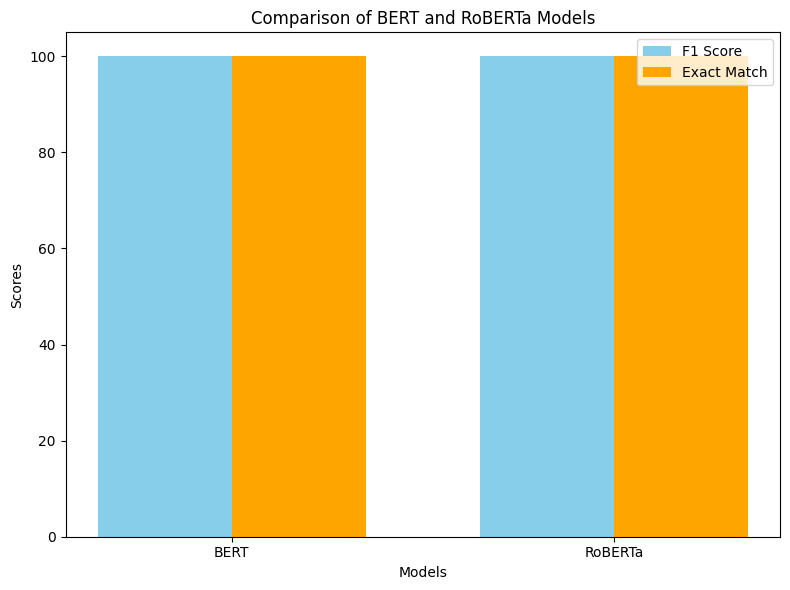

In [20]:
import matplotlib.pyplot as plt

def plot_metrics(bert_metrics, roberta_metrics):
    models = ['BERT', 'RoBERTa']
    f1_scores = [bert_metrics['f1'], roberta_metrics['f1']]
    exact_matches = [bert_metrics['exact_match'], roberta_metrics['exact_match']]

    fig, ax = plt.subplots(figsize=(8, 6))
    bar_width = 0.35
    index = range(len(models))

    bar1 = ax.bar(index, f1_scores, bar_width, label='F1 Score', color='skyblue')
    bar2 = ax.bar([i + bar_width for i in index], exact_matches, bar_width, label='Exact Match', color='orange')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of BERT and RoBERTa Models')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(models)
    ax.legend()

    plt.tight_layout()
    plt.show()  # Make sure this is included

# Example metrics for visualization
bert_example_metrics = {'f1': 100, 'exact_match': 100}
roberta_example_metrics = {'f1': 100, 'exact_match': 100}

plot_metrics(bert_example_metrics, roberta_example_metrics)
